In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

In [2]:
import sys
sys.path.insert(1, './utilities/')

from utility_functions import *

# Load the Data

In [3]:
# Loaded a set of images
root_dir = "../Datasets/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 10 # Only use 10 images for training

Loading 20 images
satImage_052.png
Loading 20 images
satImage_052.png


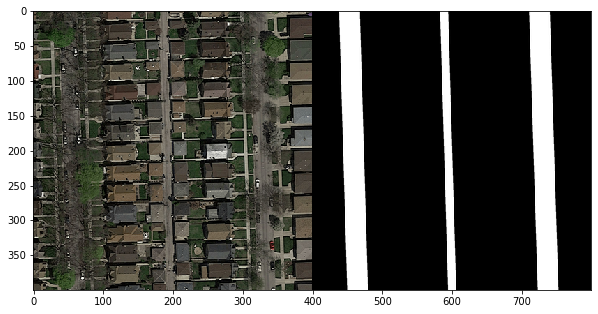

In [4]:
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

# Data Preprocessing

In [5]:
### A ajouter ici: normalization, histograms,..

## Split the images into smaller patches

In [6]:
# Extract patches from input images
# size = 10(nb_images)*625(n_patches_per_image)*16*16(size_patch)*3(nb_channels)
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
#return array of size 6250 containing all the 625 patches for all the 10 training images
#gt has only 0 or 1 values
#img has an rgb value of size 3 for each point

# Extraction of additional Features from the images

In [10]:
#More features 
from skimage.filters import prewitt_h,prewitt_v


def min_and_max_features(img):
    """
    returns the min and max rgb value for each channel
    """
    feat_max_rgb = np.max(img, axis=(0,1))
    feat_min_rgb = np.min(img, axis=(0,1))
    feat = np.append(feat_max_rgb, feat_min_rgb)
    return feat

def horizontal_and_vertical_edge_detection(image1):
    """
    applies a basic vertical and horizontal edge detection filter and then takes the mean for each channel
    """
    nb_channels = image1.shape[2]
    fest_edge_vert_avg = np.zeros((1,nb_channels))
    fest_edge_hori_avg = np.zeros((1,nb_channels))
    
    for i in range(nb_channels):
        edges_prewitt_horizontal = prewitt_h(image1[:,:,i])
        #calculating vertical edges using prewitt kernel
        edges_prewitt_vertical = prewitt_v(image1[:,:,i])
        
        fest_edge_vert_avg[0,i] = np.mean(edges_prewitt_vertical)
        fest_edge_hori_avg[0,i] = np.mean(edges_prewitt_horizontal)
        
    return np.append(fest_edge_vert_avg, fest_edge_hori_avg)

def feature_expansion(features,degree):
    """
    feature_expansion in the format X,X^2,..,X^degree (element-wise)
    """
    res = features
    iter1 = np.arange(2,degree+1,1)
    for i in iter1:
        res = np.concatenate((res,features**(i)),axis=1)
        
    return res

def add_offset(features):
    """
    adds a first column of ones to the features X
    """
    offset = np.ones((features.shape[0],1))
    return np.concatenate((offset,features),axis=1)

#rem important to condider to 2 formats : 0-1 and 0-255
import cv2

def get_gray_mask(img):
    img = img_float_to_uint8(img)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower = np.array([15,20,65])
    upper = np.array([179, 50, 255])
    mask_gray = cv2.inRange(hsv, lower, upper)
    img_res = cv2.bitwise_and(img, img, mask = mask_gray)
    #plt.imshow(mask_gray)
    #plt.show()
    #plt.imshow(img3)
    #plt.show()
    #plt.imshow(gt_imgs[0])
    #plt.show()
    
    return mask_gray

def get_grey_features(mask):
    feat_road_vert = any(np.sum(mask,axis=0)/mask.shape[0] > 0.5)
    feat_road_hori = any(np.sum(mask,axis=1)/mask.shape[1] > 0.5)
    
    return np.append(feat_road_vert,feat_road_hori)

### Definition of two classes for the patches

In [11]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

#2d features is mean + varience of grey values per patch
#for rgb we have already 6 features per patch
#the class foreground has a bit of road in it (25% min)
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [12]:
#Features definition
X1 = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))]) # dim 6
X2 = np.asarray([ min_and_max_features(img_patches[i]) for i in range(len(img_patches))]) # dim 6
X3 = np.asarray([ horizontal_and_vertical_edge_detection(img_patches[i]) for i in range(len(img_patches))]) # dim 6
X4 = np.asarray([ get_grey_features(get_gray_mask(img_patches[i])) for i in range(len(img_patches))]) # dim 2
X = np.concatenate((X1,X2,X3,X4),axis=1) # dim 20

X = feature_expansion(X,4) # dim 20 * degree
X = add_offset(X) # dim = dim + 1

In [13]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))  #TODO: fix, length(unique(Y)) 

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')
#faire diff classes selon orientation NESW de la route

Computed 6250 features
Feature dimension = 81
Number of classes = 1
Class 0: 4915 samples
Class 1: 1335 samples


# Training of the model

## 1) Logistic regression

In [14]:
# train a logistic regression classifier
from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e4, class_weight="balanced",solver='liblinear',penalty='l1')
logreg.fit(X, Y)

/Users/jerome/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=10000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
# Predict on the training set
Z = logreg.predict(X)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
print('True positive rate = ' + str(TPR))

True positive rate = 0.1696


In [ ]:
#Best score yet: 0.1696.... 

In [ ]:
#we have to add more features !! -> improve edge detection, do PCA